# Información sobre Internaciones en la Ciudad de Buenos Aires.
* Información publicada en https://data.buenosaires.gob.ar/dataset/movimiento-hospitalario

Esta información nos permite saber los servicios, especialidades y hospitales de la ciudad, y los ingresos, altas y defunciones, desde el año ***2011 al año 2017.***

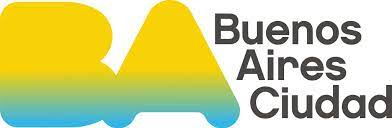

# Storytelling Internaciones-BA Ciudad

Al seleccionar el dataset con el cual trabajaría durante las clases, me incliné por uno relacionado a Salud, pero que se relacione al sector público y pueda impactar en presupuesto o políticas públicas.

Siempre he tenido interés por la Salud Pública y los sectores relacionados.
Dado que posee información sobre servicios, especialidades y hospitales de la ciudad, y los ingresos, altas y defunciones, así como camas disponibles, consideré que explora cuestiones de mi interés que me permitirá trabajar sobre la tasa de mortalidad, y ver qué impacta sobre la misma y conocer los servicios de los nosocomios públicos, que permitirán tomar acciones para bajar la tasa de mortalidad.


Al comenzar a interiorizarme con los datos suministrados, noté que había un faltante de cálculo de tasa de mortalidad en el año 2014

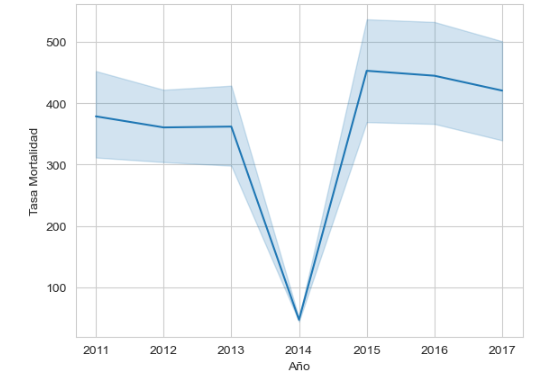

Lo llamativo de la situación, y por lo cual me di cuenta del faltante de datos, es que los ingresos y los decesos no variaban demasiado al resto de los años, por ende, no  nos encontrábamos ante una baja de la tasa de mortalidad en el 2014, sino ante un mal cálculo o un faltante de datos.

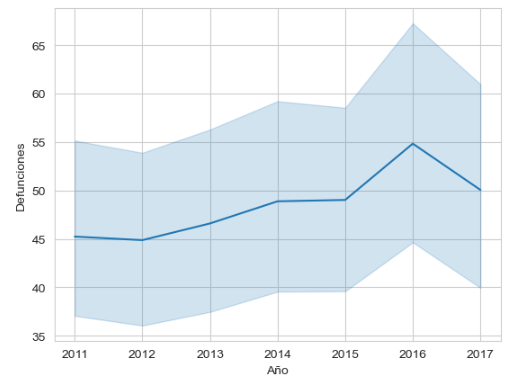

Considerando que la tasa de mortalidad es un cálculo que surge de dividir el número de muertes en un periodo entre la población media en dicho periodo y multiplicando el resultado por mil, dicidí continuar con la base realizando el cálculo en forma manual porque los datos necesarios se encontraban, a la vez de chequear en forma aleatoria el resultado de los otros años. 

Para mejor visualización agregué un código a cada Hospital (CODHOSP), y se los ha identificado por tipo de Hospital(TIPHOSP), no se encontraban en la base original.

El código de Hospital se ha identificado con una abreviatura del nombre del nosocomio.
El tipo de Hospital fue dividido en 4:
* INFANT (infanto juvenil)
* HOSPESPEC (Hospital con una especialidad específica)
* PSIQUIAT (psiquiátrico o de enfermedades mentales)
* GAGUDOS (Hospital general de agudos)

Agregué un número de servicio, identificando los mismos bajo la columna "servicio_id"

Todo esto lo realicé sobre la base en formato xlsx.

Una vez modificada la base, me puse en contexto para analizar el problema, y ver qué hipótesis y objetivos podrán ser de interés

# Contexto y Problema
* El Ministerio de Salud del Gobierno de la Ciudad Autónoma de Buenos Aires, necesita evaluar su desempeño en los Hospitales Públicos en el sector de internaciones.
Necesitan saber si la tasa de mortalidad ha aumentado, y en cuáles de sus nosocomios es mayor en el transcurso de estos 6 años para poder tomar las acciones correspondientes.

Nos provee un set de datos con información de los ingresos a internación, altas, defunciones, tasa de mortalidad. Así como también la cantidad de pacientes atendidos, el promedio de camas disponibles, servicio y especialidad, entre otros datos.



# Hipótesis y Objetivo
Tiene la impresión de que la tasa de mortalidad está relacionada al tipo de servicio de internaciones.

A su vez, ha solicitado un análisis de la cantidad de camas disponibles en los nosocomios, para saber si se requiere ampliar la capacidad de internación. Esto afectaría al presupuesto público, y al sector de Obras Públicas

**Analizaremos lo siguiente:**

* 1. 
Ha variado la tasa de mortalidad anual?
* 2. 
Con qué tipo se servicios trabajan los Hospitales?
* 3. 
Qué servicios tienen mayores ingresos?
* 3.1. 
Cuál es la tasa de mortalidad por servicio anual? y cuáles tienen mayor tasa de mortalidad?
* 3.2. 
Cuáles son los 3 Hospitales con mayor tasa de mortalidad?
* 4. 
La cantidad de camas disponibles, corresponde a la cantidad de pacientes atendidos?
* 4.1. 
Alcanzan las camas de los Hospitales para el servicio de internación?
* 5. 
Qué variables inciden más en la tasa de mortalidad?


**Librerías**

In [88]:
import json
import missingno as msno
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import sys
import joblib
import warnings
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [89]:
df = pd.read_excel('Dfinternacion.xlsx')
df.head(3)
# Tenemos columnas categóricas y numéricas, las categóricas nos brindan el nombre y tipo de Hospital, servicio y especialidad

,SERVICIO,SERVICIO_ID,ESPECIALIDADES,NOM_EFECTOR_BADATA,CODHOSP,TIPHOSP,PASES_A,ING_PASES,ALTAS,DEF,...,PAC_DIA,PROMEDIO_CAMAS_DISP,PROMEDIO_PAC_DIA,PORCENTAJE_OCUP,PROMEDIO_PERM,GIRO,TASA_MORT_HOSP,ANIO,SK_ID_EFECTOR,OBSERVACIONES
0,Cirugia,2,Urologia,HOSPITAL GENERAL DE NIÑOS RICARDO GUTIERREZ,HGNRG,INFANT,21,325,319,0,...,1820,1292,499,3861,563,2501,0,2011,2164,NaN
1,Cirugia,2,Subtotal Cirugia,HOSPITAL GENERAL DE NIÑOS RICARDO GUTIERREZ,HGNRG,INFANT,634,5295,4616,27,...,26327,13295,7213,5425,498,3978,51,2011,2164,NaN
2,Urgencia,10,Terapia Intensiva,HOSPITAL GENERAL DE NIÑOS RICARDO GUTIERREZ,HGNRG,INFANT,236,337,3,62,...,5102,1668,1398,8379,1509,2026,1834,2011,2164,NaN


In [24]:
#nuestras columnas son:
df.columns

Index(['SERVICIO', 'SERVICIO_ID', 'ESPECIALIDADES', 'NOM_EFECTOR_BADATA',
       'CODHOSP', 'TIPHOSP', 'PASES_A', 'ING_PASES', 'ALTAS', 'DEF', 'TOTAL',
       'PASES_B', 'EGR_PASES', 'DIAS_CAMAS_DISP', 'PAC_DIA',
       'PROMEDIO_CAMAS_DISP', 'PROMEDIO_PAC_DIA', 'PORCENTAJE_OCUP',
       'PROMEDIO_PERM', 'GIRO', 'TASA_MORT_HOSP', 'ANIO', 'SK_ID_EFECTOR',
       'OBSERVACIONES'],
      dtype='object')

**Dado que la columna "Observaciones" no será de nuestro interés, eliminamos la misma**

In [25]:
df = df.drop(columns=['OBSERVACIONES'])

In [26]:
df.head(1) # ya podemos visualizar nuestro df sin "observaciones"

,SERVICIO,SERVICIO_ID,ESPECIALIDADES,NOM_EFECTOR_BADATA,CODHOSP,TIPHOSP,PASES_A,ING_PASES,ALTAS,DEF,...,DIAS_CAMAS_DISP,PAC_DIA,PROMEDIO_CAMAS_DISP,PROMEDIO_PAC_DIA,PORCENTAJE_OCUP,PROMEDIO_PERM,GIRO,TASA_MORT_HOSP,ANIO,SK_ID_EFECTOR
0,Cirugia,2,Urologia,HOSPITAL GENERAL DE NIÑOS RICARDO GUTIERREZ,HGNRG,INFANT,21,325,319,0,...,4714,1820,1292,499,3861,563,2501,0,2011,2164


**Poseemos columnas categóricas y numéricas, vamos a dar una pequeña descripción de las mismas:**


* SERVICIO: Corresponde al  servicio de ingreso del paciente en Hospital
* SERVICIO_ID: número que se le asignado a cada uno de los 10 servicios
* CODHOSP: abreviatura del nombre del nosocomio
* TIPHOSP: tipo o especialidad, se dividen en 4
* ESPECIALIDADES: tipo de especialidad del servicio
* TOTAL: La sumatoria entres de los pacientes que fallecieron y los que fueron dados de alta 
* ALTAS:cantidad de pacientes dados de alta 
* DEF:cantidad de pacientes fallecidos 
* TASA_MORT_HOSP: Tasa de mortalidad del Hospital 
* PORCENTAJE_OCUP_ porcentaje ocupación Hospital
* ANIO: año de ingreso del paciente
* NOM_EFECTOR_BADATA, CODHOSP,SK_ID_EFECTOR : nombre del Hospital, abreviatura y código.
* PAC_DIA: pacientes diarios
* PROMEDIO_CAMAS_DISP: promedio de camas disponibles
* PROMEDIO_PAC_DIA:promedio de pacientes diarios
* PROMEDIO_PERM: promedio de permanencia en internación
* GIRO,PASES_A,PASES_B,ING_PASES: movimientos e/Hospitales
* SK_ID_EFECTOR: id del hospital

In [93]:
#Trabajaremos ahora con:
df[["SERVICIO","CODHOSP","TOTAL","TIPHOSP","ALTAS","DEF","TASA_MORT_HOSP","ANIO","NOM_EFECTOR_BADATA"]].head(3)

,SERVICIO,CODHOSP,TOTAL,TIPHOSP,ALTAS,DEF,TASA_MORT_HOSP,ANIO,NOM_EFECTOR_BADATA
0,Cirugia,HGNRG,319,INFANT,319,0,0,2011,HOSPITAL GENERAL DE NIÑOS RICARDO GUTIERREZ
1,Cirugia,HGNRG,4643,INFANT,4616,27,51,2011,HOSPITAL GENERAL DE NIÑOS RICARDO GUTIERREZ
2,Urgencia,HGNRG,65,INFANT,3,62,1834,2011,HOSPITAL GENERAL DE NIÑOS RICARDO GUTIERREZ


# Comenzamos a responder las preguntas

**1.Ha variado la tasa de mortalidad anual?**

Text(0.5, 1.0, 'Tasa de Mortalidad Anual')

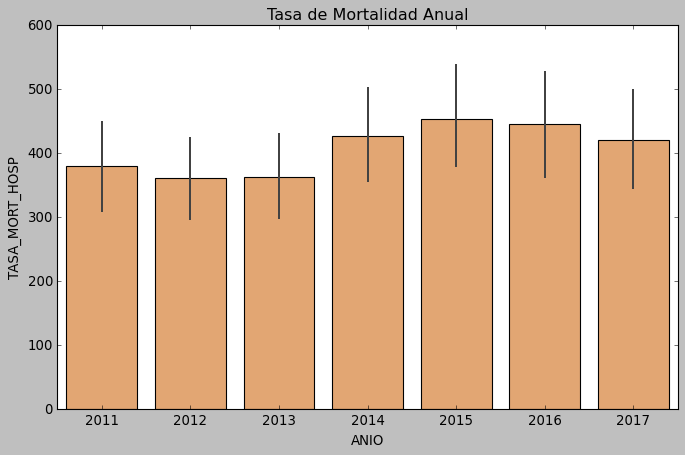

In [34]:
#Tasa de mortalidad anual
plt.figure(figsize=(10,6))
sns.barplot(y='TASA_MORT_HOSP',x='ANIO',color = 'sandybrown',data=df);
plt.title('Tasa de Mortalidad Anual')

Podemos observar que hay un pequeño incremento de la curva hacia el año 2014, sube minimamente en el 2015, y va decreciendo hacia el 2017.
Sin embargo la diferencia de la tasa de mortalidad en estos 7 años observados no es significativa.

**2. Con qué tipo se servicios trabajan los Hospitales?**

In [35]:
#Observamos con qué tipo de servicios trabajan los nosocomios

print(df['SERVICIO'].unique())

['Cirugia' 'Urgencia' 'Pediatria' 'Tocoginecologia' 'Medicina'
 'Internacion De Corta Estadia' 'Area Indiferenciada'
 'Cuidados Genereales - Area Indiferenciada' 'Cuidados Especiales']


Los servicios que poseen los Hospitales se encuentran divididos en 10. Los pacientes son destinados a alguno de éstos, según su afección/ingreso.

**3. Qué servicios poseen mayores ingresos?**

Text(0.5, 1.0, 'Pacientes por Servicio Anual')

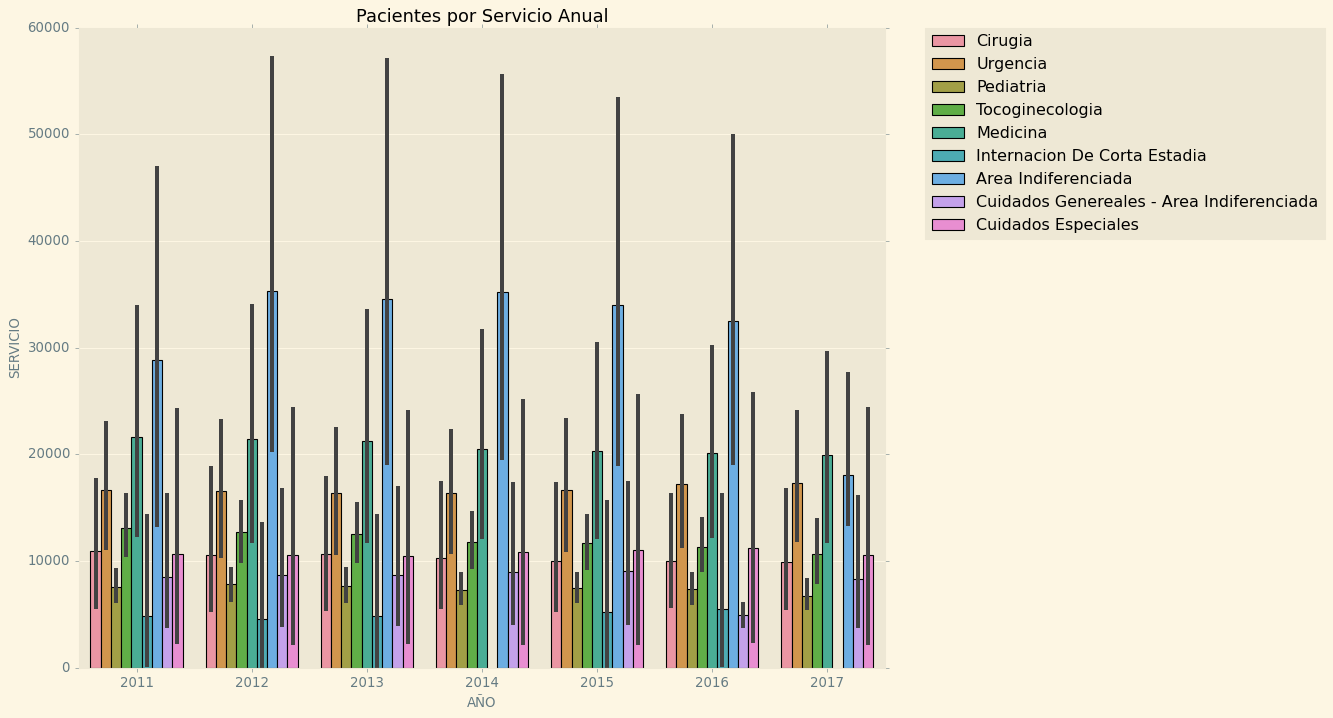

In [57]:
#Pacientes por Servicio

import seaborn as sns
plt.figure(figsize=(13,10))
ax.set_facecolor('bisque')
sns.barplot(y='PAC_DIA',x='ANIO',hue='SERVICIO',data=df);
plt.xlabel('AÑO')
plt.ylabel('SERVICIO')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('Pacientes por Servicio Anual')

In [58]:
df.groupby('SERVICIO')[['PAC_DIA']].sum() 

,PAC_DIA
SERVICIO,
Area Indiferenciada,1285004
Cirugia,8343124
Cuidados Especiales,602061
Cuidados Genereales - Area Indiferenciada,566713
Internacion De Corta Estadia,74628
Medicina,13573463
Pediatria,2987461
Tocoginecologia,1984473
Urgencia,9385310


Los servicios que poseen mayor ingreso de pacientes son:
* Medicina 13573463
* Urgencia9385310
* Cirugia 8343124
* Pediatria 2987461
* Tocoginecologia 1984473

**3.1 Cuál es la tasa de mortalidad por servicio anual?**

Text(0.5, 1.0, 'Defunciones por Servicio Anual')

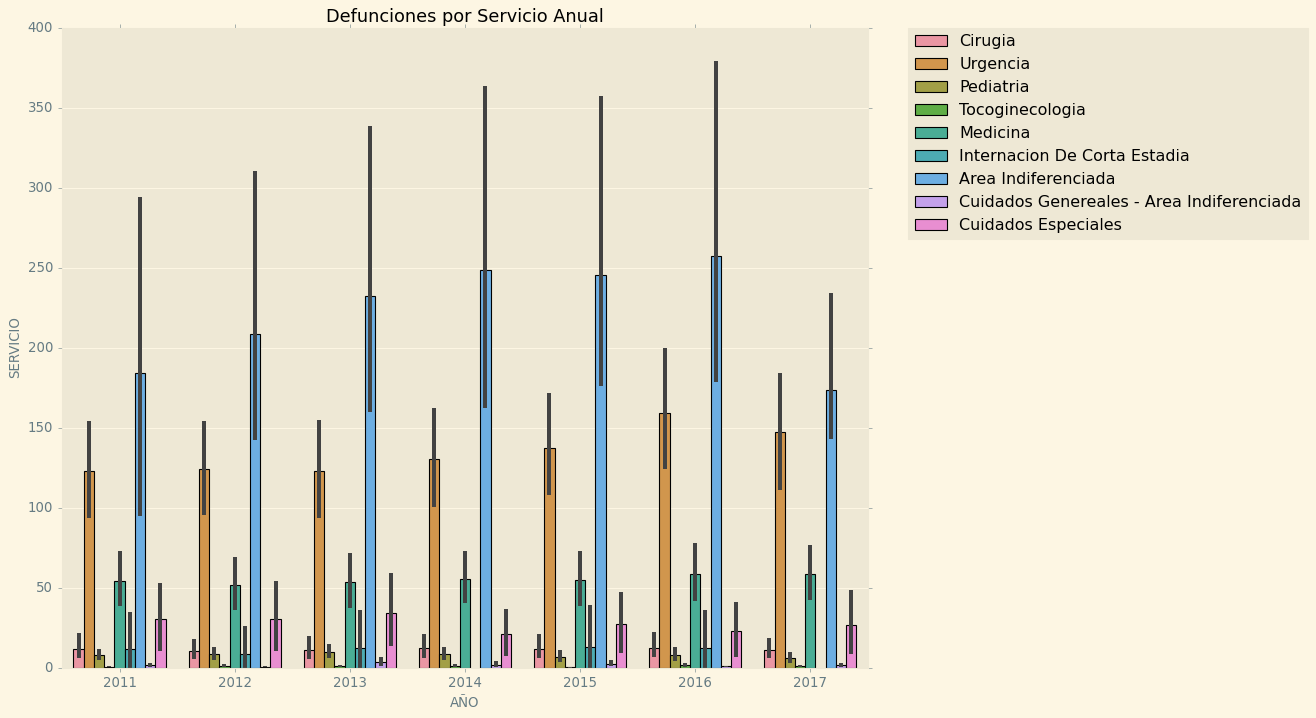

In [50]:

#Analizamos primero las defunciones por servicio anual

import seaborn as sns
plt.figure(figsize=(13,10))
ax.set_facecolor('bisque')
sns.barplot(y='DEF',x='ANIO',hue='SERVICIO', data=df);
plt.xlabel('AÑO')
plt.ylabel('SERVICIO')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('Defunciones por Servicio Anual')

In [51]:
df.groupby('SERVICIO')[['DEF']].sum() 

,DEF
SERVICIO,
Area Indiferenciada,8954
Cirugia,9188
Cuidados Especiales,1535
Cuidados Genereales - Area Indiferenciada,112
Internacion De Corta Estadia,172
Medicina,36048
Pediatria,3192
Tocoginecologia,128
Urgencia,75546


Text(0.5, 1.0, 'Tasa de mortal. por Servicio Anual')

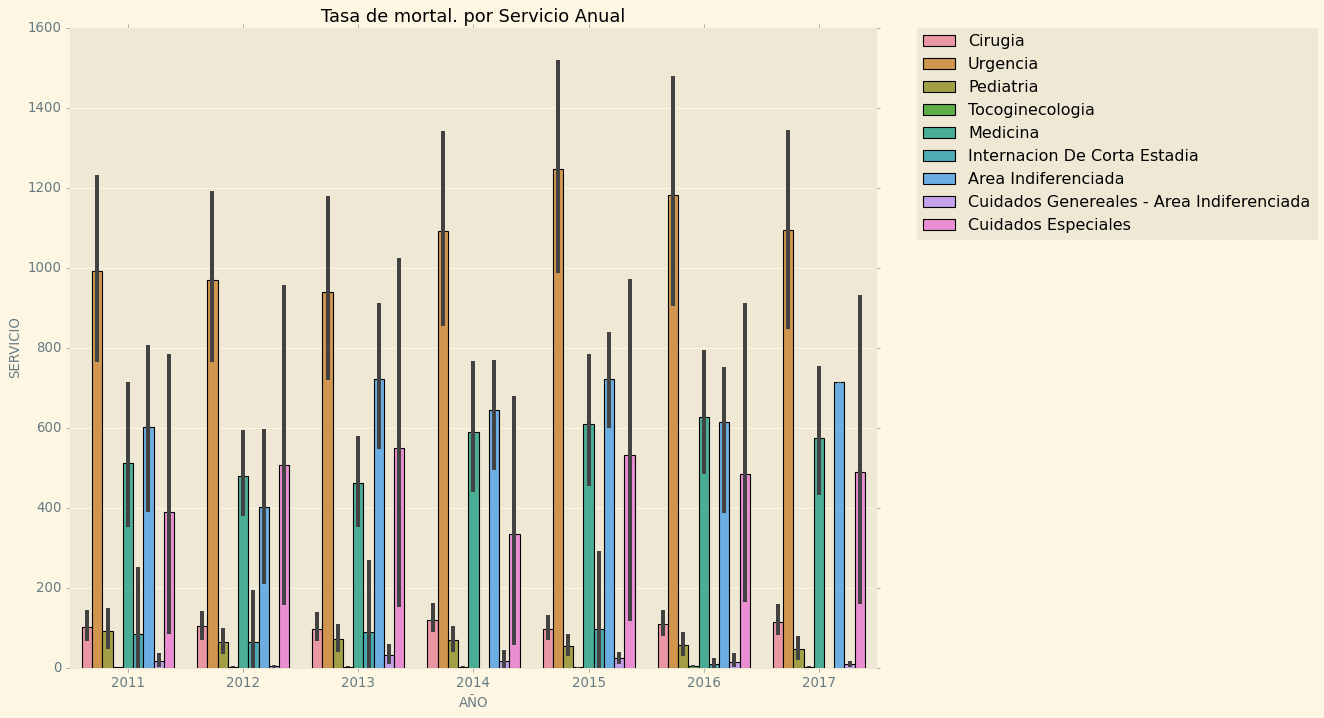

In [90]:
#Y la tasa de mortalidad por servicio anual

import seaborn as sns
plt.figure(figsize=(13,10))
ax.set_facecolor('bisque')
sns.barplot(y='TASA_MORT_HOSP',x='ANIO',hue='SERVICIO',data=df);
plt.xlabel('AÑO')
plt.ylabel('SERVICIO')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('Tasa de mortal. por Servicio Anual')

In [53]:
df.groupby('SERVICIO')[['TASA_MORT_HOSP']].sum() 

,TASA_MORT_HOSP
SERVICIO,
Area Indiferenciada,24949
Cirugia,85313
Cuidados Especiales,26249
Cuidados Genereales - Area Indiferenciada,1108
Internacion De Corta Estadia,1030
Medicina,359443
Pediatria,26184
Tocoginecologia,284
Urgencia,602273


Text(0, 0.5, 'DEF. Y TASA MORT X SERVICIO')

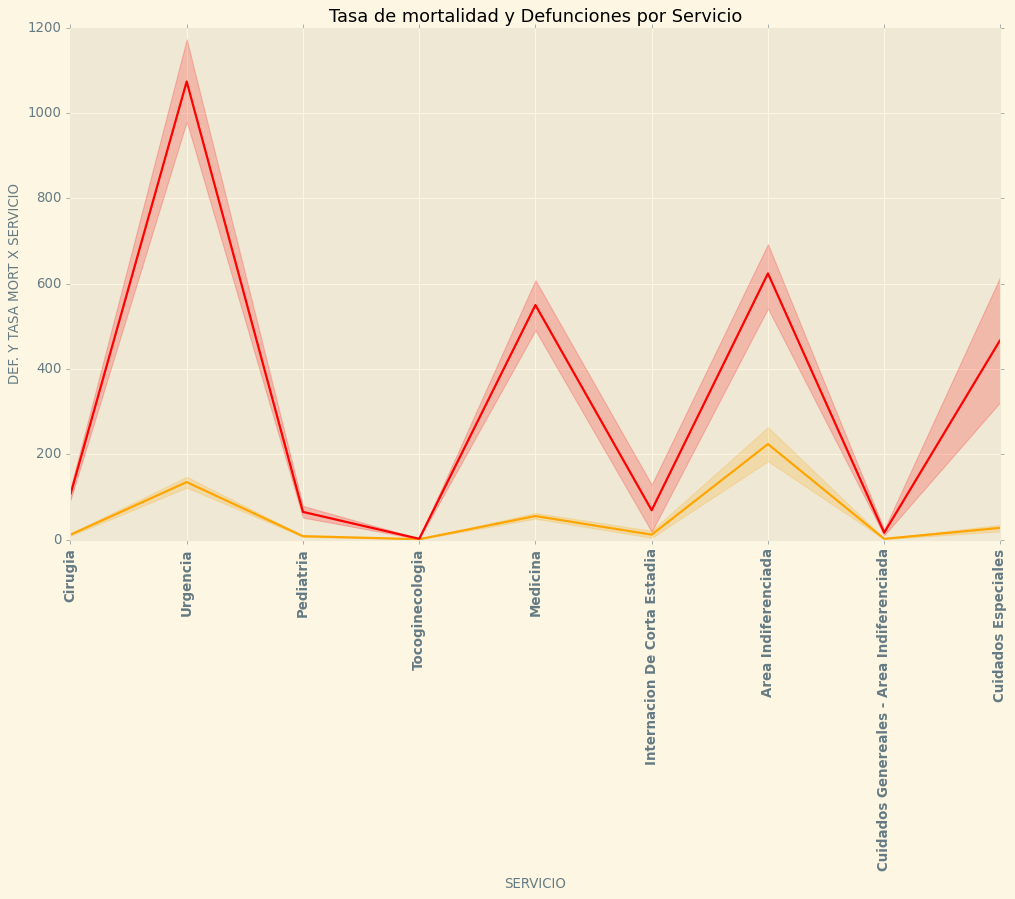

In [66]:
#Visualicemos juntas la tasa de mortalidad y las defunciones por Servicio

plt.figure(figsize=(15,8))
may_flights = df
sns.lineplot(data=df, x="SERVICIO", y="DEF",color = 'orange')
plt.xlabel('SERVICIO')
plt.ylabel('DEF. Y TASA MORT X SERVICIO ')
plt.title('Tasa de mortalidad y Defunciones por Servicio')
plt.xticks(rotation=90, weight = 'bold')

may_flights = df
sns.lineplot(data=df, x="SERVICIO", y="TASA_MORT_HOSP", color = 'red',)
plt.xlabel('SERVICIO')
plt.ylabel('DEF. Y TASA MORT X SERVICIO')


Podemos observar que URGENCIA, MEDICINA Y CIRUGIA son los servicios con mayor tasa de mortalidad

**3.2. Cuáles son los 3 Hospitales con mayor tasa de mortalidad?**

In [67]:
df.NOM_EFECTOR_BADATA.value_counts()

HOSPITAL GENERAL DE AGUDOS J. M. RAMOS MEJIA                187
HOSPITAL GENERAL DE AGUDOS DR. C. DURAND                    179
HOSPITAL GENERAL DE AGUDOS DONACION F. SANTOJANNI           171
HOSPITAL GENERAL DE AGUDOS B. RIVADAVIA                     163
HOSPITAL GENERAL DE AGUDOS DR C. ARGERICH                   161
HOSPITAL GENERAL DE AGUDOS DR. I. PIROVANO                  153
HOSPITAL GENERAL DE AGUDOS DR. J. A. FERNANDEZ              148
HOSPITAL GENERAL DE AGUDOS DR. T. ALVAREZ                   147
HOSPITAL GENERAL DE NIÑOS PEDRO DE ELIZALDE                 133
HOSPITAL GENERAL DE NIÑOS RICARDO GUTIERREZ                 126
HOSPITAL GENERAL DE AGUDOS J. A. PENNA                      118
HOSPITAL GENERAL DE AGUDOS D. VELEZ SARSFIELD               117
HOSPITAL GENERAL DE AGUDOS DR. E. TORNU                     105
HOSPITAL DE INFECCIOSAS F. MUÑIZ                            100
HOSPITAL DE QUEMADOS DR. ARTURO UMBERTO ILLIA                96
HOSPITAL GENERAL DE AGUDOS P. PIÑERO    

Text(0.5, 1.0, 'Defunciones por Hospital')

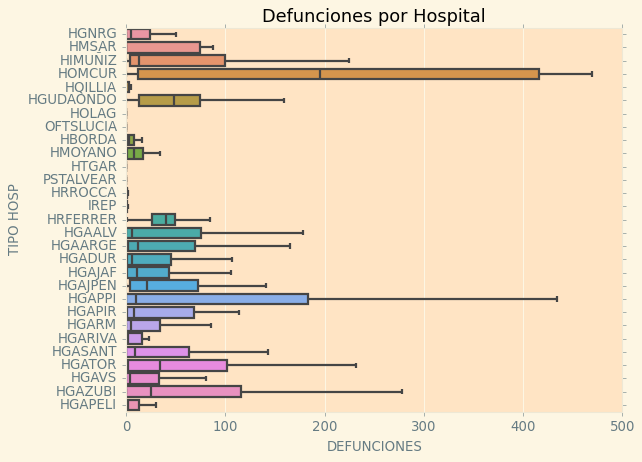

In [68]:
#Lo graficamos utilizando el nombre de Hosp con su abreviatura para ver las defunciones por Hospital
ax = sns.boxplot(x="DEF", y="CODHOSP", data=df,showfliers=False)
ax.set_facecolor('bisque')
plt.xlabel('DEFUNCIONES')
plt.ylabel('TIPO HOSP')
plt.title('Defunciones por Hospital')

Text(0.5, 1.0, 'Defunciones por Tipo de Hospital')

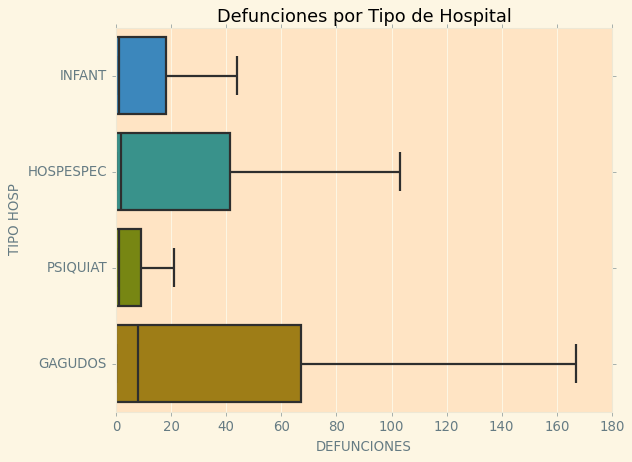

In [69]:
# Realizamos el mismo análisis por tipo de Hospital
ax = sns.boxplot(x="DEF", y="TIPHOSP", data=df,showfliers=False)
ax.set_facecolor('bisque')
plt.xlabel('DEFUNCIONES')
plt.ylabel('TIPO HOSP')
plt.title('Defunciones por Tipo de Hospital')
#Destacan Hosp. de agudos y de especialidades (quemados, enf.infecciosas,oftalmología,gastoenterología,oncología,rehabilitación)

In [70]:
#Buscamos la tasa de mortalidad dado que la misma depende de los ingresos, teniendo en cuenta el cálculo de este valor
#Las defunciones de gráficos anteriores pueden ser altas, pero quizás tener mayor cantidad de ingreso a internaciones
df.groupby('CODHOSP')[['TASA_MORT_HOSP']].sum()

,TASA_MORT_HOSP
CODHOSP,
HBORDA,8883
HGAALV,57227
HGAARGE,62743
HGADUR,79012
HGAJAF,48815
HGAJPEN,55681
HGAPELI,27357
HGAPIR,63794
HGAPPI,34820


Text(0.5, 1.0, 'Tasa de mort. por Hospital')

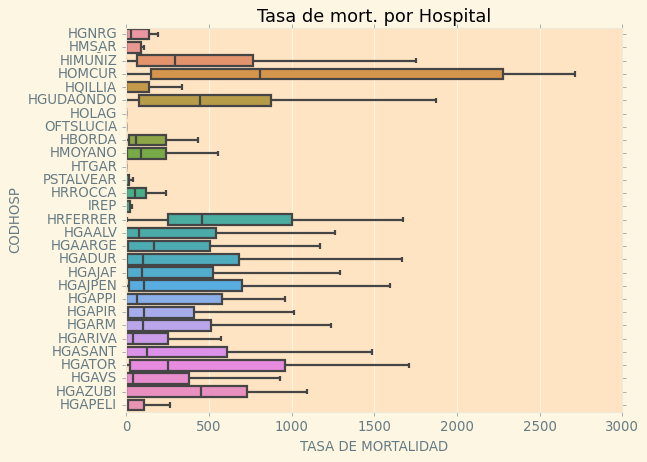

In [71]:
ax = sns.boxplot(x="TASA_MORT_HOSP", y="CODHOSP", data=df,showfliers=False)
ax.set_facecolor('bisque')
plt.xlabel('TASA DE MORTALIDAD')
plt.ylabel('CODHOSP')
plt.title('Tasa de mort. por Hospital')

Text(0.5, 1.0, 'Tasa de mort. por Tipo de Hospital')

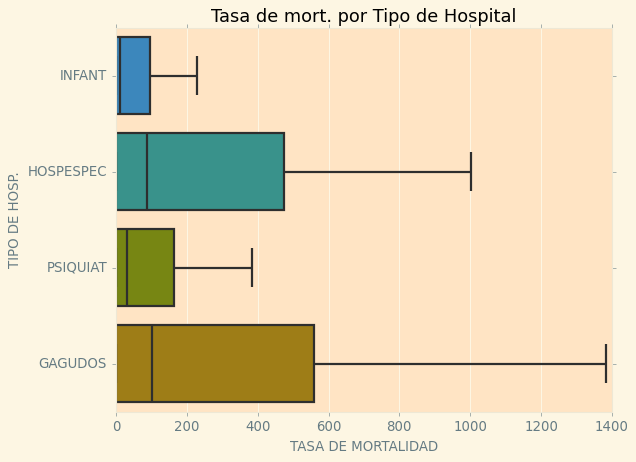

In [75]:
#Buscamos la tasa de mortalidad por tipo de hospital

ax = sns.boxplot(x="TASA_MORT_HOSP", y="TIPHOSP",data=df,showfliers=False)
ax.set_facecolor('bisque')
plt.xlabel('TASA DE MORTALIDAD')
plt.ylabel('TIPO DE HOSP.')
plt.title('Tasa de mort. por Tipo de Hospital')

#Los Hospitales de Especialidades y de Agudos poseen la mayor tasa de mortalidad

In [76]:
df.groupby('TIPHOSP')[['TOTAL','ALTAS','DEF']].sum()

,TOTAL,ALTAS,DEF
TIPHOSP,,,
GAGUDOS,2462812,2355330,107482
HOSPESPEC,406308,385167,21141
INFANT,667232,661715,5517
PSIQUIAT,50091,49356,735


In [77]:
df.groupby('TIPHOSP')[['TASA_MORT_HOSP']].sum()

,TASA_MORT_HOSP
TIPHOSP,
GAGUDOS,812150
HOSPESPEC,227419
INFANT,58878
PSIQUIAT,28386


Los Hospitales que poseen mayor tasa de mortalidad son:

* HGASANT(HOSPITAL GENERAL DE AGUDOS DONACION F. SANTOJANNI)	97922
* HGATOR	(HOSPITAL GENERAL DE AGUDOS DR. E. TORNU) 84345
* HIMUÑIZ	(HOSPITAL DE INFECCIOSAS F. MUÑIZ) 80264


En cuanto a los tipos de Hospitales con mayor tasa de mortalidad son los hospitales de agudos y de especialidades.

**4.La cantidad de camas disponibles, corresponde a la cantidad de pacientes atendidos?**

In [94]:
# Ahora, evaluamos en nuestro análisis los pacientes diarios, el promedio de pacientes y las camas disponibles
df[[ "PAC_DIA","PROMEDIO_CAMAS_DISP","PROMEDIO_PAC_DIA",
    "CODHOSP","TIPHOSP","ANIO","TOTAL"]].head(3)

,PAC_DIA,PROMEDIO_CAMAS_DISP,PROMEDIO_PAC_DIA,CODHOSP,TIPHOSP,ANIO,TOTAL
0,1820,1292,499,HGNRG,INFANT,2011,319
1,26327,13295,7213,HGNRG,INFANT,2011,4643
2,5102,1668,1398,HGNRG,INFANT,2011,65


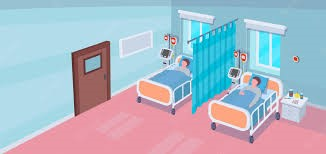

Text(0, 0.5, 'Promedio de camas por pacientes atendidos')

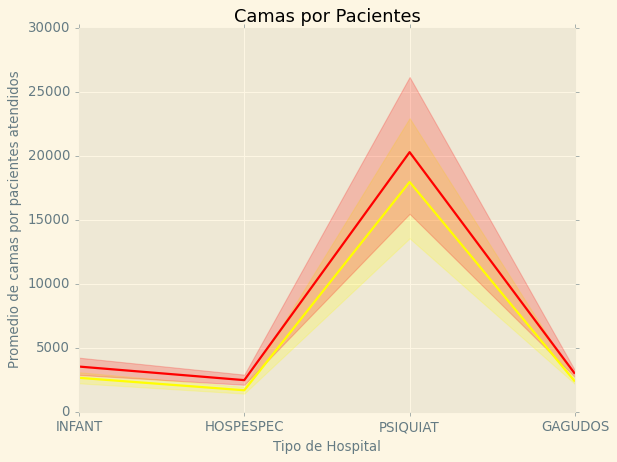

In [79]:
# Analizamos el promedio de camas por el promedio de pacientes atendidos
may_flights = df
sns.lineplot(data=df, x="TIPHOSP", y="PROMEDIO_PAC_DIA",color = 'yellow')
plt.xlabel('Tipo de Hospital')
plt.ylabel('Promedio de camas por pacientes atendidos')
plt.title('Camas por Pacientes')

may_flights = df
sns.lineplot(data=df, x="TIPHOSP", y="PROMEDIO_CAMAS_DISP",color = 'red')
plt.xlabel('Tipo de Hospital')
plt.ylabel('Promedio de camas por pacientes atendidos')


Observamos que la cantidad de camas disponibles supera levemente la cantidad de pacientes.
Es Importante tener en cuenta que no todas las consultas devienen en una internación.

**4.1. Alcanzan las camas de los Hospitales para el servicio de internación?**

Text(0, 0.5, 'Promedio de camas y Total intern')

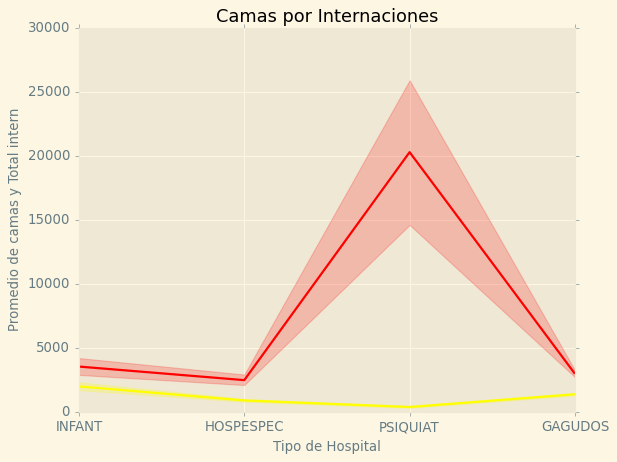

In [80]:
#Veamos ahora, según el total de internaciones, si se dispone de la cantidad de camas suficientes
may_flights = df
sns.lineplot(data=df, x="TIPHOSP", y="TOTAL",color = 'yellow')
plt.xlabel('Tipo de Hospital')
plt.ylabel('Promedio de camas y Total intern')
plt.title('Camas por Internaciones')

may_flights = df
sns.lineplot(data=df, x="TIPHOSP", y="PROMEDIO_CAMAS_DISP",color = 'red')
plt.xlabel('Tipo de Hospital')
plt.ylabel('Promedio de camas y Total intern')


El siguiente gráfico nos demuestra que las internaciones son menores a las camas disponibles

**5. Qué variables inciden más en la tasa de mortalidad?**

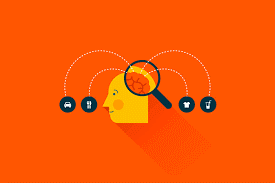

**Nos quedaremos sólo con nuestras variables numéricas**

In [81]:
df = df.drop(columns=['SERVICIO', 'ESPECIALIDADES','NOM_EFECTOR_BADATA', 'CODHOSP','TIPHOSP'])

#El nombre de los Hospitales está definido por"SK_ID_EFECTOR"
#El nombre de los Servicios por "Servicio ID"

In [82]:
df.columns

Index(['SERVICIO_ID', 'PASES_A', 'ING_PASES', 'ALTAS', 'DEF', 'TOTAL',
       'PASES_B', 'EGR_PASES', 'DIAS_CAMAS_DISP', 'PAC_DIA',
       'PROMEDIO_CAMAS_DISP', 'PROMEDIO_PAC_DIA', 'PORCENTAJE_OCUP',
       'PROMEDIO_PERM', 'GIRO', 'TASA_MORT_HOSP', 'ANIO', 'SK_ID_EFECTOR'],
      dtype='object')

**Realizamos una matriz de correlación para poder responder a la consulta**

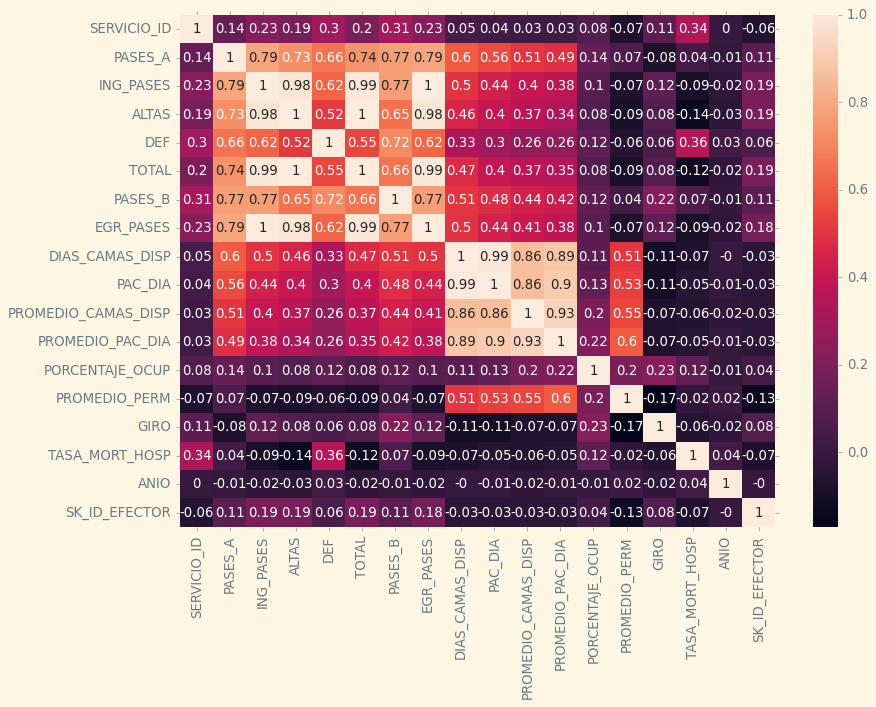

In [85]:

correlation_matrix = df.corr().round(2)
correlation_matrix

plt.figure(figsize=(12,8))
sns.heatmap(data=correlation_matrix, annot=True)
plt.show()


Vemos que DEF y servicio_id son las variables más relacionadas a la Tasa de Mortalidad, seguidas de PORCENTAJE_OCUP

<AxesSubplot:xlabel='TASA_MORT_HOSP', ylabel='PORCENTAJE_OCUP'>

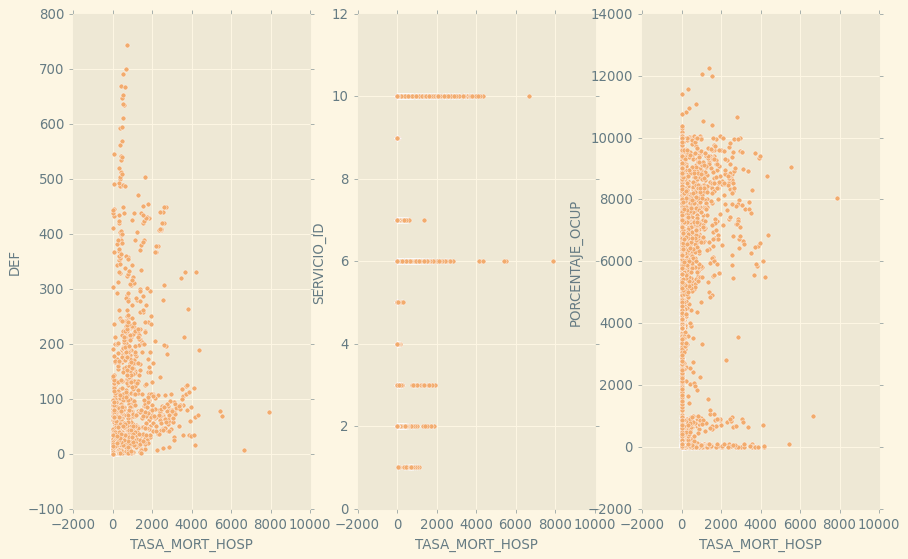

In [86]:
plt.figure(figsize=(13,17))
plt.subplot(2,3,1)
sns.scatterplot(x="TASA_MORT_HOSP",y="DEF",data=df,color='#F2AB6D')
plt.subplot(2,3,2)
sns.scatterplot(x="TASA_MORT_HOSP",y="SERVICIO_ID",data=df,color='#F2AB6D')
plt.subplot(2,3,3)
sns.scatterplot(x="TASA_MORT_HOSP",y="PORCENTAJE_OCUP",data=df,color='#F2AB6D')


  
    
    
    
    
# **Interpretación y Conclusiones**




* La tasa de mortalidad comienza a incrementarse en el 2014 con un pico en el 2015 y un leve descenso al final de los 2 años.

* Se registra mayor tasa de mortalidad en CIRUGIA,MEDICINA y URGENCIA.

* Los Hospitales con mayor tasa de mortalidad son: HOSPITAL SANTOJANNI, HOSPITAL DE INFECCIOSAS F. MUÑIZ,HOSPITAL GENERAL DE AGUDOS DR. E. TORNU.

* Concluímos que Los Hospitales de Especialidades y de Agudos poseen la mayor tasa de mortalidad.

* En cuanto a la disponibilidad de camas, son muy superiores a la cantidad de internaciones, y sobre todo en los Hospitales de Salud mental.

* Lo que más incide en la Tasa de Mortalidad es DEF y SERVICIO_ID y PORCENTAJE_OCUP.



Luego de este análisis nos encontramos en condiciones de informarle al Ministerio de Salud, que no será necesario realizar una ampliación de camas en los nosocomios públicos.
Que si bien la tasa de mortalidad se mantiene sin variaciones importantes que impliquen aumentos o descensos descomunales, será importantes poner foco en los servicios de Medicina, Cirugía y Urgencia.
Quizás se podrían reforzar estos servicios en general, y también realizar un análisis detallado en los Hospitales con mayor tasa de mortalidad.